In [1]:
##センチメントアルゴリズムの実装
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

In [2]:
##ニュースデータの生成
#データの設定
k = 10   
year_count = 10
month = np.tile(np.arange(12), year_count) + 1
year = np.repeat(np.arange(year_count), 12) + 2010
n = len(year)   #経済指標発表数
m = np.repeat(0, n)  
for i in range(n):
    m[i] = calendar.monthrange(year[i], month[i])[1]
d = np.sum(m)   #日付数
month_id = np.repeat(np.arange(n), m)
day_id = np.array(list(itertools.chain(*[np.array(range(m[i]), dtype="int") for i in range(n)])))
days = day_id.shape[0]   #日付数
v1 = 50   #ポジティブニュース数
v2 = 50   #ネガティブニュース数
N1 = days*v1; N2 = days*v2
k_vec = np.repeat(1.0, k)

In [3]:
#idを設定
d_id1 = np.repeat(np.arange(days), v1)
d_id2 = np.repeat(np.arange(days), v2)
news_id1 = np.tile(np.arange(v1), days)
news_id2 = np.tile(np.arange(v2), days)

In [4]:
##日付およびニュースインデックスを定義
#日付インデックスを定義
days_list1 = [i for i in range(days)]
days_list2 = [i for i in range(days)]
for i in range(days):
    days_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
    days_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int")

#ニュースインデックスを定義
news_list1 = [i for i in range(v1)]
news_list2 = [i for i in range(v2)]
for i in range(v1):
    news_list1[i] = np.array(np.where(news_id1==i)[0], dtype="int")
for i in range(v2):
    news_list2[i] = np.array(np.where(news_id2==i)[0], dtype="int")

In [5]:
##センチメントの状態の推移を生成
#モデルパラメータの定義
s = 5
S1 = np.array([0.05, 0.15, 0.6, 0.15, 0.05])
S2 = np.array([[0.8389, 0.15, 0.01, 0.001, 0.0001],
               [0.15, 0.8089, 0.03, 0.001, 0.0001],
               [0.01, 0.02, 0.95, 0.02, 0.01],
               [0.0001, 0.001, 0.03, 0.8089, 0.15],
               [0.0001, 0.001, 0.01, 0.15, 0.8389]])

#状態推移を生成
z = np.repeat(0, days)
for i in range(days):
    if i==0:
        z[i] = np.argmax(np.random.multinomial(1, S1, 1))
    else:
        z[i] = np.argmax(np.random.multinomial(1, S2[z[i-1], ], 1))

#回帰行列を生成
scale = 1.5
beta_positive = np.abs(np.random.normal(0.0, 0.7, k))
beta_neutral = np.abs(np.random.normal(0.0, 0.3, k))
beta_negative = np.abs(np.random.normal(0.0, 0.7, k))
beta = np.vstack((scale*beta_positive, beta_positive, beta_neutral, beta_negative, scale*beta_negative))
np.sum(np.diag(np.repeat(1.0, s))[z, ], axis=0)

array([ 548.,  517., 1218.,  678.,  691.])

In [6]:
###### 応答変数を生成
#モデルパラメータの生成
beta_u1 = np.random.gamma(0.25, 1/1.0, days)
beta_u2 = np.random.gamma(0.25, 1/1.0, days)
beta_v1 = np.random.gamma(0.2, 1/1.0, v1)
beta_v2 = np.random.gamma(0.2, 1/1.0, v2)
theta_u = np.random.gamma(beta[z, ], 1/1.0).reshape(days, k)
theta_v1 = np.random.gamma(np.full((v1, k), beta_positive), 1/1.0)
theta_v2 = np.random.gamma(np.full((v2, k), beta_negative), 1/1.0)
betat_u1 = beta_u1.copy(); betat_u2 = beta_u2.copy(); betat_v1 = beta_v1.copy(); betat_v2 = beta_v2.copy()
thetat_u = theta_u.copy(); thetat_v1 = theta_v1.copy(); thetat_v2 = theta_v2.copy()

#ポアソン分布からニュース頻度を生成
uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
mu1 = beta_u1[d_id1] + beta_v1[news_id1] + uv1
mu2 = beta_u2[d_id2] + beta_v2[news_id2] + uv2
y1 = np.random.poisson(mu1, N1)
y2 = np.random.poisson(mu2, N2)

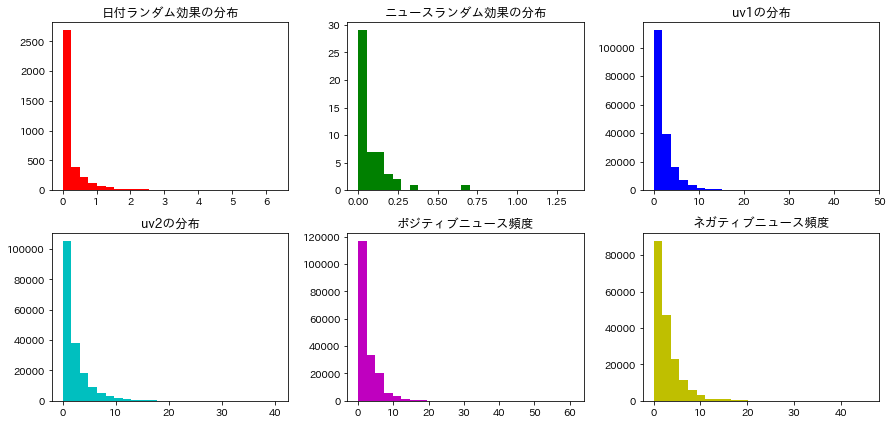

In [7]:
#生成したデータのヒストグラム
dt = [beta_u1, beta_v1, uv1, uv2, y1, y2]
fig_range = np.append(np.array([np.min(np.append(beta_u1, beta_u2)), np.min(np.append(beta_v1, beta_v2)), 
                                np.min(uv1), np.min(uv2), 0.0, 0.0]), 
                      np.array([np.max(np.append(beta_u1, beta_u2)), np.max(np.append(beta_v1, beta_v2)), 
                                np.max(uv1), np.max(uv2), np.max(y1), np.max(y2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["日付ランダム効果の分布", "ニュースランダム効果の分布", "uv1の分布", "uv2の分布",
          "ポジティブニュース頻度", "ネガティブニュース頻度"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

Text(0.5,1,'センチメントスコアの推移')

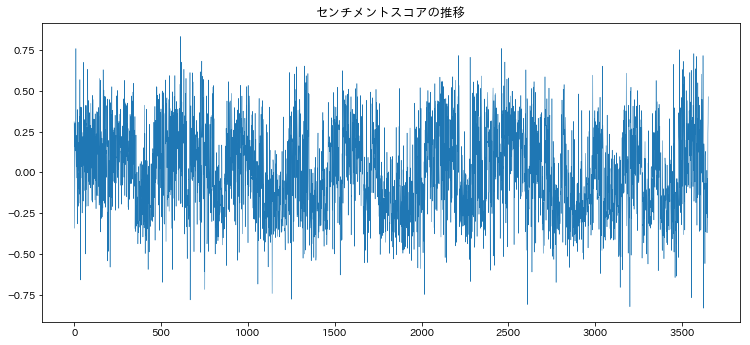

In [8]:
#センチメント指数の真値の推移
n_prob = np.repeat(0.0, days)
p_prob = np.repeat(0.0, days)
for i in range(days):
    p_prob[i] = np.sum(y1[days_list1[i]]) / np.sum(y1[days_list1[i]] + y2[days_list2[i]])
    n_prob[i] = np.sum(y2[days_list2[i]]) / np.sum(y1[days_list1[i]] + y2[days_list2[i]])
score_true = p_prob - n_prob
fig = plt.figure(figsize=(12.5, 5.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(score_true, lw=0.5)
plt.title("センチメントスコアの推移", fontsize=12.5)

In [9]:
####センチメントモデルのパラメータをサンプリング####
##アルゴリズムの設定
R = 1000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 50

In [10]:
#事前分布の設定
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.1
alpha3 = 0.1; beta3 = 0.1

In [11]:
##パラメータの真値
#モデルパラメータの真値
intercept1 = np.repeat(1.0, N1)[:, np.newaxis]
intercept2 = np.repeat(1.0, N2)[:, np.newaxis]
beta_u1 = betat_u1.copy()
beta_u2 = betat_u2.copy()
beta_v1 = betat_v1.copy()
beta_v2 = betat_v2.copy()
theta_u = thetat_u.copy()
theta_v1 = thetat_v1.copy()
theta_v2 = thetat_v2.copy()

#期待値の真値
beta_day1 = beta_u1[d_id1]; beta_day2 = beta_u2[d_id2]
beta_news1 = beta_v1[news_id1]; beta_news2 = beta_v2[news_id2]
uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
mu1 = beta_u1[d_id1] + beta_v1[news_id1] + uv1
mu2 = beta_u2[d_id2] + beta_v2[news_id2] + uv2
mut1 = mu1.copy(); mut2 = mu2.copy()

In [12]:
##パラメータの初期値
#モデルパラメータの初期値
intercept1 = np.repeat(1.0, N1)[:, np.newaxis]
intercept2 = np.repeat(1.0, N2)[:, np.newaxis]
beta_u1 = np.random.gamma(0.2, 1/1.0, days)
beta_u2 = np.random.gamma(0.2, 1/1.0, days)
beta_v1 = np.random.gamma(0.2, 1/1.0, v1)
beta_v2 = np.random.gamma(0.2, 1/1.0, v2)
theta_u = np.random.gamma(0.25, 1/1.0, days*k).reshape(days, k)
theta_v1 = np.random.gamma(0.2, 1/1.0, v1*k).reshape(v1, k)
theta_v2 = np.random.gamma(0.2, 1/1.0, v2*k).reshape(v2, k)

#期待値の初期値
beta_day1 = beta_u1[d_id1]; beta_day2 = beta_u2[d_id2]
beta_news1 = beta_v1[news_id1]; beta_news2 = beta_v2[news_id2]
uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
mu1 = beta_u1[d_id1] + beta_v1[news_id1] + uv1
mu2 = beta_u2[d_id2] + beta_v2[news_id2] + uv2

In [13]:
#サンプリング結果の格納用配列
BETA_U1 = np.zeros((int(R/keep), days))
BETA_U2 = np.zeros((int(R/keep), days))
BETA_V1 = np.zeros((int(R/keep), v1))
BETA_V2 = np.zeros((int(R/keep), v2))
THETA_U = np.zeros((days, k, int(R/keep)))
THETA_V1 = np.zeros((v1, k, int(R/keep)))
THETA_V2 = np.zeros((v2, k, int(R/keep)))

In [14]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst1 = np.sum(scipy.stats.poisson.logpmf(y1, np.mean(y1)))
LLst2 = np.sum(scipy.stats.poisson.logpmf(y2, np.mean(y2)))
LLst = LLst1 + LLst2
print(np.round([LLst1, LLst2, LLst], 1))

#真値での対数尤度
LLbest1 = np.sum(scipy.stats.poisson.logpmf(y1, mut1))
LLbest2 = np.sum(scipy.stats.poisson.logpmf(y2, mut2))
LLbest = LLbest1 + LLbest2
print(np.round([LLbest1, LLbest2, LLbest], 1))

[-474843.8 -488588.9 -963432.7]
[-289539.8 -287540.  -577079.8]


In [15]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##時間パラメータをサンプリング
    #補助変数lambdaを更新
    lambda_deploy1 = theta_u[d_id1, ] * theta_v1[news_id1, ]
    lambda_deploy2 = theta_u[d_id1, ] * theta_v2[news_id2, ]
    Lambda1 = np.hstack((beta_day1[:, np.newaxis], lambda_deploy1)) / mu1[:, np.newaxis]
    Lambda2 = np.hstack((beta_day2[:, np.newaxis], lambda_deploy2)) / mu2[:, np.newaxis]

    #時間パラメータの事後分布のパラメータ
    lambda_y1 = Lambda1 * y1[:, np.newaxis]
    lambda_y2 = Lambda2 * y2[:, np.newaxis]
    lambda_h1 = np.hstack((intercept1, theta_v1[news_id1, ]))
    lambda_h2 = np.hstack((intercept2, theta_v2[news_id2, ]))
    w11 = np.repeat(0.0, days); w12 = np.repeat(0.0, days)
    w21 = np.repeat(0.0, days); w22 = np.repeat(0.0, days)
    W1 = np.zeros((days, k)); W2 = np.zeros((days, k))
    for i in range(days):
        w11[i] = np.sum(lambda_y1[days_list1[i], 0]); w21[i] = np.sum(lambda_y2[days_list1[i], 0])
        w12[i] = np.sum(lambda_h1[days_list1[i], 0]); w22[i] = np.sum(lambda_h2[days_list2[i], 0])
        W1[i, ] = np.sum(np.vstack((lambda_y1[days_list1[i], 1:], lambda_y2[days_list2[i], 1:])), axis=0)
        W2[i, ] = np.sum(np.vstack((lambda_h1[days_list1[i], 1:], lambda_h2[days_list2[i], 1:])), axis=0)
    w11 = w11 + alpha1; w12 = w12 + beta1; w21 = w21 + alpha1; w22 = w22 + beta1
    W1 = W1 + alpha2; W2 = W2 + beta2

    #ガンマ分布からパラメータをサンプリング
    beta_u1 = np.random.gamma(w11, 1/w12, days)
    beta_u2 = np.random.gamma(w21, 1/w22, days)
    theta_u = np.random.gamma(W1, 1/W2)

    #期待値を更新
    beta_day1 = beta_u1[d_id1]; beta_day2 = beta_u2[d_id2]
    beta_news1 = beta_v1[news_id1]; beta_news2 = beta_v2[news_id2]
    uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
    uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
    mu1 = beta_day1 + beta_news1 + uv1
    mu2 = beta_day2 + beta_news2 + uv2


    ##ニュースパラメータをサンプリング
    #補助変数lambdaを更新
    lambda_deploy1 = theta_u[d_id1, ] * theta_v1[news_id1, ]
    lambda_deploy2 = theta_u[d_id2, ] * theta_v2[news_id2, ]
    Lambda1 = np.hstack((beta_news1[:, np.newaxis], lambda_deploy1)) / mu1[:, np.newaxis]
    Lambda2 = np.hstack((beta_news2[:, np.newaxis], lambda_deploy2)) / mu2[:, np.newaxis]

    #ニュースパラメータの事後分布のパラメータ
    lambda_y1 = Lambda1 * y1[:, np.newaxis]
    lambda_y2 = Lambda2 * y2[:, np.newaxis]
    lambda_h1 = np.hstack((intercept1, theta_u[d_id1, ]))
    lambda_h2 = np.hstack((intercept2, theta_u[d_id2, ]))
    h11 = np.repeat(0.0, v1); h12 = np.repeat(0.0, v1)
    h21 = np.repeat(0.0, v2); h22 = np.repeat(0.0, v2)
    H11 = np.zeros((v1, k)); H12 = np.zeros((v1, k))
    H21 = np.zeros((v2, k)); H22 = np.zeros((v2, k))
    for i in range(v1):
        h11[i] = np.sum(lambda_y1[news_list1[i], 0]); h12[i] = np.sum(lambda_h1[news_list1[i], 0])
        H11[i, ] = np.sum(lambda_y1[news_list1[i], 1:], axis=0)
        H12[i, ] = np.sum(lambda_h1[news_list1[i], 1:], axis=0)
    for i in range(v2):
        h21[i] = np.sum(lambda_y2[news_list2[i], 0]); h22[i] = np.sum(lambda_h2[news_list2[i], 0])
        H21[i, ] = np.sum(lambda_y2[news_list2[i], 1:], axis=0)
        H22[i, ] = np.sum(lambda_h2[news_list2[i], 1:], axis=0)

    #ガンマ分布からパラメータをサンプリング
    beta_v1 = np.random.gamma(h11, 1/h12, v1); beta_v2 = np.random.gamma(h21, 1/h22, v2)
    theta_v1 = np.random.gamma(H11, 1/H12); theta_v2 = np.random.gamma(H21, 1/H22)

    #期待値を更新
    beta_day1 = beta_u1[d_id1]; beta_day2 = beta_u2[d_id2]
    beta_news1 = beta_v1[news_id1]; beta_news2 = beta_v2[news_id2]
    uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
    uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
    mu1 = beta_day1 + beta_news1 + uv1
    mu2 = beta_day2 + beta_news2 + uv2


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA_U1[mkeep] = beta_u1
        BETA_U2[mkeep] = beta_u2
        BETA_V1[mkeep] = beta_v1
        BETA_V2[mkeep] = beta_v2
        THETA_U[:, :, mkeep] = theta_u
        THETA_V1[:, :, mkeep] = theta_v1
        THETA_V2[:, :, mkeep] = theta_v2

    #サンプリング結果の表示
    if rp%disp==0:
        #対数尤度を更新
        LL1 = np.sum(scipy.stats.poisson.logpmf(y1, mu1))
        LL2 = np.sum(scipy.stats.poisson.logpmf(y2, mu2))
        LL = LL1 + LL2

        #結果の表示
        print(rp)
        print(np.round(np.array([LL1, LL2, LL, LLbest1, LLbest2, LLbest]), 1))

0
[-415382.3 -418040.6 -833422.9 -289539.8 -287540.  -577079.8]
50
[-305601.1 -294796.2 -600397.3 -289539.8 -287540.  -577079.8]
100
[-300074.2 -291938.7 -592012.8 -289539.8 -287540.  -577079.8]
150
[-297962.6 -290229.7 -588192.3 -289539.8 -287540.  -577079.8]
200
[-295973.2 -289372.3 -585345.6 -289539.8 -287540.  -577079.8]
250
[-294353.3 -287873.5 -582226.8 -289539.8 -287540.  -577079.8]
300
[-293878.9 -287460.5 -581339.4 -289539.8 -287540.  -577079.8]
350
[-293903.  -287097.6 -581000.6 -289539.8 -287540.  -577079.8]
400
[-293993.5 -286902.6 -580896.1 -289539.8 -287540.  -577079.8]
450
[-293930.5 -286864.2 -580794.7 -289539.8 -287540.  -577079.8]
500
[-293951.4 -286910.1 -580861.5 -289539.8 -287540.  -577079.8]
550
[-293973.9 -286760.6 -580734.6 -289539.8 -287540.  -577079.8]
600
[-293969.7 -286731.1 -580700.8 -289539.8 -287540.  -577079.8]
650
[-293853.8 -286725.2 -580578.9 -289539.8 -287540.  -577079.8]
700
[-293941.9 -286717.3 -580659.2 -289539.8 -287540.  -577079.8]
750
[-293917.

In [16]:
##センチメント指数を計算
#センチメントの格納用配列
RS = np.arange(burnin, int(R/keep))
rs = RS.shape[0]
total_value = np.zeros((days, rs))
positive_prob = np.zeros((days, rs))
negative_prob = np.zeros((days, rs))

for i in range(rs):
    #期待値を定義
    index = RS[i]
    beta_day1 = BETA_U1[index][d_id1] ; beta_day2 = BETA_U2[index][d_id2]
    beta_news1 = BETA_V1[index][news_id1]; beta_news2 = BETA_V2[index][news_id2]
    uv1 = np.dot(THETA_U[:, :, index][d_id1, ] * THETA_V1[:, :, index][news_id1, ], k_vec)
    uv2 = np.dot(THETA_U[:, :, index][d_id2, ] * THETA_V2[:, :, index][news_id2, ], k_vec)
    mu1 = beta_day1 + beta_news1 + uv1
    mu2 = beta_day2 + beta_news2 + uv2

    #ポジティブとネガティブ確率を計算
    total = np.repeat(0.0, days)
    positive = np.repeat(0.0, days)
    negative = np.repeat(0.0, days)
    for j in range(days):
        total[j] = np.sum(mu1[days_list1[j], ]) + np.sum(mu2[days_list2[j]])
        positive[j] = np.sum(mu1[days_list1[j]]) / total[j]
        negative[j] = np.sum(mu2[days_list2[j]]) / total[j]

    #結果を格納
    total_value[:, i] = total
    positive_prob[:, i] = positive
    negative_prob[:, i] = negative

Text(0.5,1,'センチメントスコアの真値の推移')

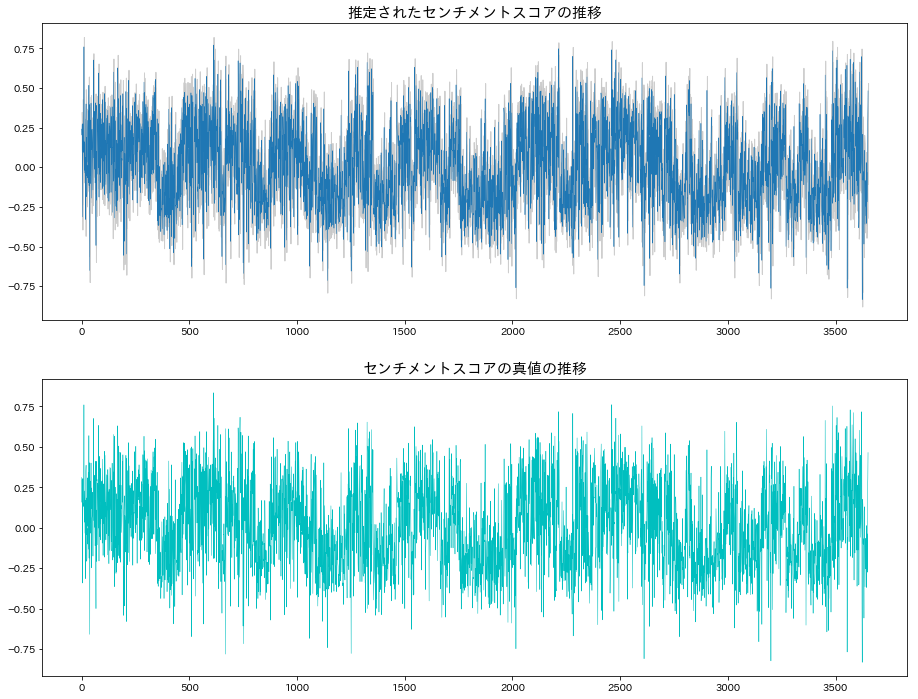

In [17]:
##センチメントスコアの計算とプロット
#センチメントスコアの計算
positive_mu = np.mean(positive_prob, axis=1)
negative_mu = np.mean(negative_prob, axis=1)
sentiment_mu = positive_mu - negative_mu
sentiment_percentile = np.percentile(positive_prob - negative_prob, [2.5, 97.5], axis=1).T

#センチメントスコアのプロット
target = days
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(15.5, 12.0))
ax = fig.add_subplot(2, 1, 1)
ax.plot(sentiment_mu[:target], lw=0.5)
ax.fill_between(np.arange(days)[:target], sentiment_percentile[:, 0][:target], sentiment_percentile[:, 1][:target],
                color='#888888', alpha=0.4)
plt.title("推定されたセンチメントスコアの推移", fontsize=15.0)

ax = fig.add_subplot(2, 1, 2)
ax.plot(score_true, color="c", lw=0.5)
plt.title("センチメントスコアの真値の推移", fontsize=15.0)